In [1]:
from enum import Enum

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

import os

# Add directory where 'latex' is installed
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

plt.style.use(['science', 'grid', 'retro'])

In [2]:
ROOT = Path().cwd()

RESULTS_DIR = ROOT / "results" # mes/paper_experiments/results
SAVE_DIR = ROOT / "plots" # mes/paper_experiments/paper_plots

SAVE_DIR.mkdir(parents=True, exist_ok=True)

assert RESULTS_DIR.exists(), f"{RESULTS_DIR} does not exist"


# Load All Data

In [ ]:
def load_and_concat_json_files(*, results_dir: Path) -> pd.DataFrame:
    """
    Load all the individual JSON files from each run and concatenate them into a 
    single dataframe.

    Args:
        results_dir: The absolute path to the directory containing the JSON files

    Returns:
        df_master: A dataframe with the results of all the runs
    """
    # I was an idiot and forgot to include the acq fun in the BO runs,
    # so we have to parse it from the filename for now. This has since
    # been fixed, but we keep this for now for backwards compatibility.
    acq_funs = [
        "expected_improvement",
        "random_search",
        "ves_gamma_0_0",
        "ves_gamma_0_1",
        "ves_gamma_0_2",
        "ves_mc_gamma",
        "ves_exp_0",
        "ves_exp_1",
        "ves_exp_2",
        "ves_mc_exponential",
        "ves_lr_0_0",
        "ves_lr_0_1",
        "ves_lr_0_2",
        "ves_lr_2_0",
        "ves_lr_2_1",
        "ves_lr_2_2",
        "ves_mc_gaussian",
    ]
    def parse_af_from_name(filename:str) -> str:
        return [af for af in acq_funs if af in filename][0]


    res_files = list(results_dir.glob("*.json"))
    print(f"Found {len(res_files)} files in {results_dir}")

    df_list = []
    for file in res_files:
        df_i = pd.read_json(file)
        df_i["acq_func"] = parse_af_from_name(str(file))
        df_list.append(df_i)
    df_master = pd.concat(df_list)

    print(f"Parsed {len(res_files)} files with {len(df_master)} rows")
    return df_master


def load_results_cached(*, results_subfolder: str) -> pd.DataFrame:
    """
    Load the results from the given subfolder. If a cached version of the results
    exists, load it from there. Otherwise, load the results from the subfolder and
    save the results to the cache.

    Args:
        results_subfolder: The subfolder containing the results, e.g. "0"

    Returns:
        A dataframe with the results of all the runs
    """
    df_master_filename = RESULTS_DIR / f"{results_subfolder}_results_data.csv.gz"

    if not df_master_filename.exists():
        df_master = load_and_concat_json_files(results_dir=RESULTS_DIR / results_subfolder)
        df_master.to_csv(df_master_filename, index=False, compression="gzip")
        print(f"Saved {len(df_master)} rows to {df_master_filename}")
    else:
        df_master = pd.read_csv(df_master_filename)
        print(f"Loaded {len(df_master)} rows from {df_master_filename}")

    return df_master


# folder "0" has all runs used in the paper results section and linear regression models log_std(y_n1)
results_subfolder_1 = "0"

# folder 3 has the results where linear regression models std(y_n1) and not log_std(y_n1)
results_subfolder_2 = "3_2025-08-29_11-19-48_ddbb58f61780759f5a50ae8c57ce148ec88236fd"

df_master_1 = load_results_cached(results_subfolder=results_subfolder_1)
df_master_2 = load_results_cached(results_subfolder=results_subfolder_2)


# lr_mask = df_master_1["acq_func"].str.contains("ves_lr")
# df_master_1 = df_master_1[~lr_mask]

# print(df_master_1["acq_func"].unique())


df_master = pd.concat([df_master_1]) #, df_master_2], axis=0, ignore_index=True)

print(df_master["acq_func"].unique())
print(df_master.shape)



Loaded 329800 rows from /Users/michaelp/mes/paper_experiments/results/0_results_data.csv.gz
Loaded 116400 rows from /Users/michaelp/mes/paper_experiments/results/3_2025-08-29_11-19-48_ddbb58f61780759f5a50ae8c57ce148ec88236fd_results_data.csv.gz
['ves_exp_2' 'ves_gamma_0_0' 'ves_mc_exponential' 'ves_lr_0_2'
 'ves_lr_2_1' 'expected_improvement' 'random_search' 'ves_gamma_0_2'
 'ves_lr_2_2' 'ves_lr_0_1' 'ves_exp_0' 'ves_mc_gamma' 'ves_gamma_0_1'
 'ves_lr_0_0' 'ves_mc_gaussian' 'ves_exp_1' 'ves_lr_2_0']
(329800, 14)


## Computing Mean, STD for each kernel/AF/dim/ynoise/lenscale

And a single plotting functions

In [28]:
class Result_columns(Enum):
    y_max_diff = "y_max_diff"
    y_rec_diff_max = "y_rec_diff_max"
    y_max_var = "y_max_var"
    y_rec_var = "y_rec_var"


# nice user friendly names for the acquisition functions to use
# in plot legend.
ALG_NAMES = {
    "expected_improvement": "EI",
    "random_search": "RS",
    "ves_gamma_0_0": r"$\Gamma$ Constant",
    "ves_gamma_0_1": r"$\Gamma$ Linear",
    "ves_gamma_0_2": r"$\Gamma$ ReLu",
    "ves_mc_gamma": r"$\Gamma$ MC",
    "ves_exp_0": r"Exp Constant",
    "ves_exp_1": r"Exp Linear",
    "ves_exp_2": r"Exp ReLu",
    "ves_mc_exponential": r"Exp MC",
    "ves_lr_0_0": r"$\mathcal{N}$ L-C",
    "ves_lr_0_1": r"$\mathcal{N}$ L-L",
    "ves_lr_0_2": r"$\mathcal{N}$ L-R",
    "ves_lr_2_0": r"$\mathcal{N}$ R-C",
    "ves_lr_2_1": r"$\mathcal{N}$ R-L",
    "ves_lr_2_2": r"$\mathcal{N}$ R-R",
    "ves_mc_gaussian": r"$\mathcal{N}$ MC",
}

for alg_name in list(ALG_NAMES.keys()):
    ALG_NAMES[alg_name + "_log"] = ALG_NAMES[alg_name] + " (log)"


def group_data(*, df:pd.DataFrame, col:Result_columns) -> pd.DataFrame:
    """
    Compute means and average convergence curve for each
     - kernel
     - dimension
     - length scale
     - acquisition function
     - y noise standard deviation

    col may be one of:
        "y_max_diff"
        "y_rec_diff_max"
        "y_max_var"
        "y_rec_var"

    This gives us a multi-index dataframe with unique nested keys
    and mean, std, count regret for each row.
    To index into a single kernel / dimension, we can use:

        index = (kernel_type, len_scale, n_dim, y_noise_std, acq_func, steps)
        df_grouped.loc[index] # returns mean, std, count

    Args:
        df: The dataframe to group and aggregate
        col: The column to aggregate

    Returns:
        A dataframe with the mean, std, and count of the column
        for each kernel/dim/len/af/y_std
    """
    group_cols = [
        "kernel_type",
        "len_scale",
        "n_dim",
        "y_noise_std",
        "acq_func",
        "steps"
    ]

    df = df.copy()
    df = df.explode([col, "steps"], ignore_index=True) # explode history into seperate rows
    df[col] = pd.to_numeric(df[col], errors="raise")

    df = df[group_cols + [col]]

    df_grouped = df.groupby(group_cols)
    df_grouped = df_grouped[col].agg(['mean', 'std', 'count'])

    return df_grouped


def plot_single(
    *,
    df:pd.DataFrame,
    ax:plt.Axes,
    acq_funs:list[str]=None,
    err_scale:float=0.674, # +/- 50% confidence intervals
) -> None:
    """
    Plot all the acquisition functions here on the same plot
    """
    if acq_funs is None:
        acq_funs = df.index.get_level_values('acq_func').unique()

    for acq_func in acq_funs:
        acq_data = df.loc[acq_func]
        x = acq_data.index
        y = acq_data["mean"]
        y_err = acq_data['std'] / np.sqrt(acq_data['count'])
        ax.plot(x, y, label=ALG_NAMES[acq_func])
        ax.fill_between(x, y - y_err * err_scale, y + y_err * err_scale, alpha=0.2)
    ax.legend(framealpha=0.5, loc="lower left")
    ax.set_yscale("log")


In [29]:
def plot_everything_in_one_massive_figure(
    *,
    df_grouped: pd.DataFrame,
    af_groups: list[list[str]]=None,
) -> plt.Figure:
    """
    Just plot everything available in the df_grouped. Ooptionally filter for
    specific acq funs. 

    Args:
        df_grouped: The dataframe with the results
        af_groups: A list of lists of acq fun names to plot. If None, plot all acq funs.
    
    NOTE: this is mainly for quick results overview/exploration, not paper plots
    """
    if af_groups is None:
        af_groups = [df_grouped.index.get_level_values('acq_func').unique()]

    kernels = df_grouped.index.get_level_values('kernel_type').unique()
    y_std = df_grouped.index.get_level_values('y_noise_std').unique()
    len_scales = df_grouped.index.get_level_values('len_scale').unique()
    n_dims = df_grouped.index.get_level_values('n_dim').unique()
    n_af_groups = len(af_groups)

    num_plots = n_af_groups * len(kernels) * len(len_scales) * len(n_dims) * len(y_std)

    fig, axes = plt.subplots(num_plots, 1, figsize=(10, num_plots*5))
    axes = np.asarray([axes]).flatten()

    k = 0

    # Super nested plot yeah!
    for kernel_type in kernels:
        for len_scale in len_scales:
            for n_dim in n_dims:
                for y_noise_std in y_std:

                    title = f"Kernel: {kernel_type}, Length Scale: {len_scale}, Dimension: {n_dim}, Y Noise Std: {y_noise_std:.1f}"
                    axes[k].set_title(title)

                    df_acq_func = df_grouped.loc[(kernel_type, len_scale, n_dim, y_noise_std)]

                    print(str(k) + " " + "-"*100)
                    print(f"kernel: {kernel_type}, len_scale: {len_scale}, n_dim: {n_dim}, y_noise_std: {y_noise_std}")
                    print(df_acq_func.index.get_level_values('acq_func').unique())
                    print()

                    for af_group in af_groups:
                        af_group = [af for af in af_group if af in df_acq_func.index.get_level_values('acq_func').unique()]
                        plot_single(df=df_acq_func, ax=axes[k], acq_funs=af_group)
                        k += 1
    return fig

# Plot everything to just have a look

0 ----------------------------------------------------------------------------------------------------
kernel: matern-5/2, len_scale: 5, n_dim: 2, y_noise_std: 0.0
Index(['expected_improvement', 'random_search', 'ves_exp_0', 'ves_exp_1',
       'ves_exp_2', 'ves_gamma_0_0', 'ves_gamma_0_1', 'ves_gamma_0_2',
       'ves_lr_0_0', 'ves_lr_0_1', 'ves_lr_0_2', 'ves_lr_2_0', 'ves_lr_2_1',
       'ves_lr_2_2', 'ves_mc_exponential', 'ves_mc_gamma', 'ves_mc_gaussian'],
      dtype='object', name='acq_func')

1 ----------------------------------------------------------------------------------------------------
kernel: matern-5/2, len_scale: 5, n_dim: 2, y_noise_std: 0.3
Index(['expected_improvement', 'random_search', 'ves_exp_0', 'ves_exp_1',
       'ves_exp_2', 'ves_gamma_0_0', 'ves_gamma_0_1', 'ves_gamma_0_2',
       'ves_lr_0_0', 'ves_lr_0_1', 'ves_lr_0_2', 'ves_lr_2_0', 'ves_lr_2_1',
       'ves_lr_2_2', 'ves_mc_exponential', 'ves_mc_gamma', 'ves_mc_gaussian'],
      dtype='object', name='ac

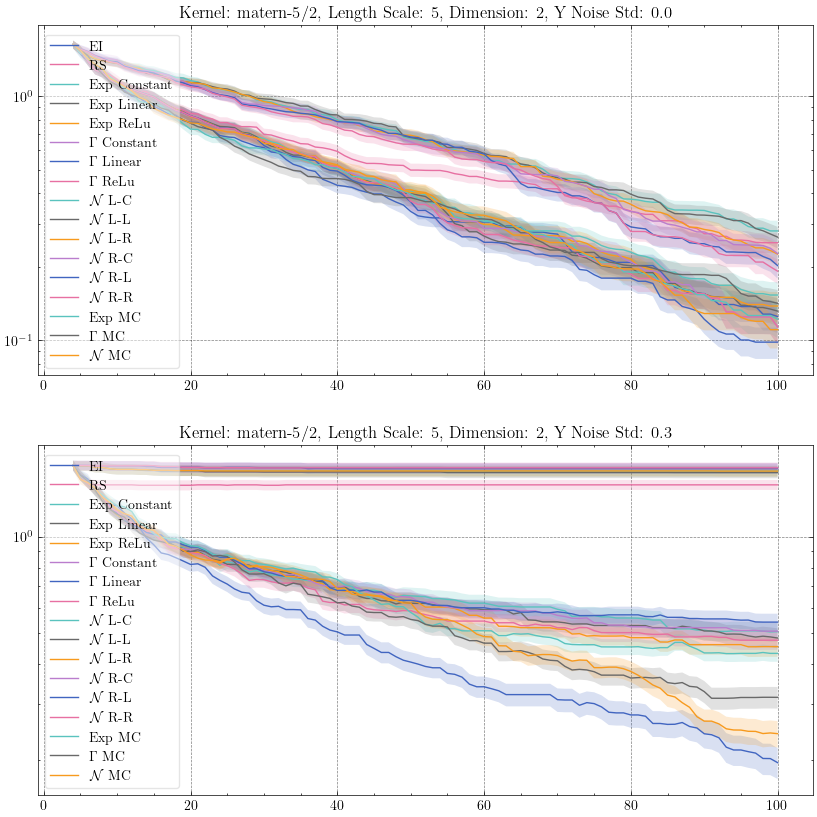

In [30]:
# df_reg_data.loc[('matern-5/2', 5, 2, 0.0)]
df_grouped = group_data(df=df_master, col="y_rec_diff_mean")
fig = plot_everything_in_one_massive_figure(df_grouped=df_grouped)

# Make one nice (2, 3) figure of results for the paper

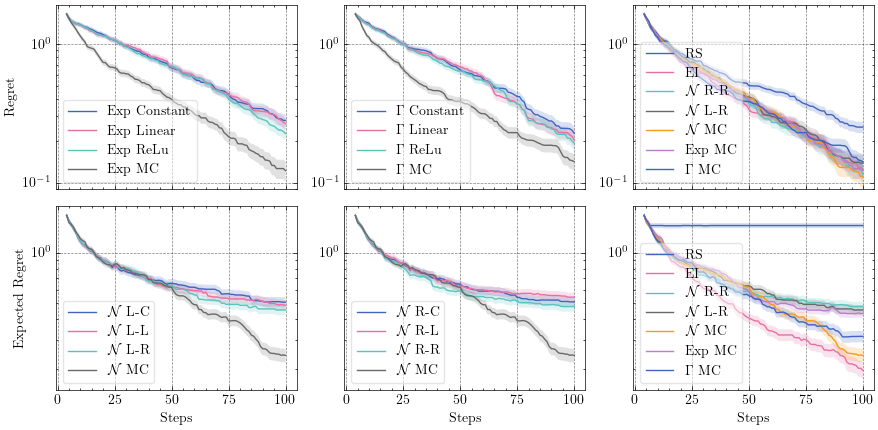

In [31]:
result_cols = [
    "y_max_diff",  # y_noise_std=0: regret for best y value seen and best possible y
    "y_rec_diff_max",  # y_noise_std>0: expected regret when using recomended x
    "y_max_var",
    "y_rec_var"
]

af_groups = [
    [
        "ves_gamma_0_0",
        "ves_gamma_0_1",
        "ves_gamma_0_2",
        "ves_mc_gamma",
    ],
    [
        "ves_exp_0",
        "ves_exp_1",
        "ves_exp_2",
        "ves_mc_exponential",
    ],
    [
        "ves_lr_0_0",
        "ves_lr_0_1",
        "ves_lr_0_2",
        "ves_mc_gaussian",
    ],
    [
        "ves_lr_2_0",
        "ves_lr_2_1",
        "ves_lr_2_2",
        "ves_mc_gaussian",
    ],
    [
        "random_search",
        "expected_improvement",
        "ves_lr_2_2",
        "ves_lr_0_2",
        "ves_mc_gaussian",
        "ves_mc_exponential",
        "ves_mc_gamma",
    ],
]


kernel_type = "matern-5/2"
len_scale = 5
n_dim = 2
y_noise_std = 0.0

y_noise_std_levels = df_master["y_noise_std"].unique()

index_det = (kernel_type, len_scale, n_dim, min(y_noise_std_levels))
index_noisy = (kernel_type, len_scale, n_dim, max(y_noise_std_levels))


fig, axes = plt.subplots(2, 3, figsize=(9, 4.5), sharex=True)

axes[0, 0].set_ylabel("Regret")
axes[1, 0].set_ylabel("Expected Regret")

for i in range(3):
    axes[1, i].set_xlabel("Steps")
    axes[0, i].set_ylim(0.09, 1.9)
    axes[1, i].set_ylim(0.15, 1.9)


axes[1, 1].set_yticklabels([])
axes[1, 2].set_yticklabels([])
axes[0, 1].set_yticklabels([])
axes[0, 2].set_yticklabels([])


# first 2 plots is just EXP and Gamma variants
df_i = group_data(df=df_master, col="y_max_diff").loc[index_det]
plot_single(df=df_i, ax=axes[0, 0], acq_funs=af_groups[1])
plot_single(df=df_i, ax=axes[0, 1], acq_funs=af_groups[0])


# next two plots are LR variants on noisy
df_i = group_data(df=df_master, col="y_rec_diff_mean").loc[index_noisy]
plot_single(df=df_i, ax=axes[1, 0], acq_funs=af_groups[2])
plot_single(df=df_i, ax=axes[1, 1], acq_funs=af_groups[3])


# final two plots: noise free and noisy for VES algos + EI + RS
df_i = group_data(df=df_master, col="y_max_diff").loc[index_det]
plot_single(df=df_i, ax=axes[0, 2], acq_funs=af_groups[4])

df_i = group_data(df=df_master, col="y_rec_diff_mean").loc[index_noisy]
plot_single(df=df_i, ax=axes[1, 2], acq_funs=af_groups[4])

fig.tight_layout()

fig.savefig(SAVE_DIR / "paper_results.pdf")
